# Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1)

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
arena_members = pd.read_csv('data/data_arena_members.csv')
arenas = pd.read_csv('data/data_arenas.csv')

In [3]:
arena_members = arena_members.merge(arenas[['arena_id', 'battle_type_id', 'battle_level_id', 'winner_team_id']], how='left', on='arena_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,2790,15,20,16533,0,0,0,1,9,2
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,829,15,10,4468,0,0,0,1,9,2
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,240,15,10,5419,1030,0,0,1,9,2
3,2018-09-16,7N1T221ccNyadyccT,202,ca1a2y2cy,1,0,0,0,529,330,...,343,15,10,18874,0,0,0,1,9,2
4,2018-09-16,7N1T221ccNyadyccT,202,caca47y7a,2,0,0,0,10257,379,...,3190,15,20,10470,840,0,0,1,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427925,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,494,15,10,26773,1560,0,0,1,8,1
2427926,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1415,15,10,3869,1790,0,0,1,8,1
2427927,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,380,15,10,58261,390,0,0,1,8,1
2427928,2018-10-10,cTacc2711d4da4y,202,c44d7NNNa,2,500138173,0,0,15649,336,...,337,15,10,27681,0,0,0,1,8,1


# Utils

In [124]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_network(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    
    return model

def plot_network_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
    plt.ylim([0,1])
    plt.legend()

    plt.show()

# Catalog cleaning

In [5]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows. ({100 * (1 - len(catalog) / N)} %)')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows. ({100 * len(removed_tanks) / (len(removed_tanks) + len(catalog))} %)')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows. (0.7882882882882858 %)
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows. (1.0215664018161208 %)
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows. (11.238532110091748 %)
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows. (2.5839793281653756 %)
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows. (0.13262599469495706 %)

Totally removed 135 rows. (15.202702702702704 %)


In [6]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

classEncoder = LabelEncoder()
catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


In [7]:
N0 = len(catalog)

print(f'Catalog shape: {catalog.shape}\n')

N = len(catalog)
print('[REMOVING DUPLICATES...]', end='   ')
catalog = catalog.dropna()
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

N = len(catalog)
print('[REMOVING NAN...]', end='   ')
catalog = catalog[~catalog.isna()]
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

print(f'\nTotally removed {N0 - len(catalog)} rows. ({100 * (1 - len(catalog) / N0)} %)\n')

catalog.info()

Catalog shape: (753, 6)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   item_cd            753 non-null    category
 1   item_class         753 non-null    int32   
 2   item_price_credit  753 non-null    int64   
 3   item_price_gold    753 non-null    int64   
 4   item_level         753 non-null    int64   
 5   crew_size          753 non-null    int64   
dtypes: category(1), int32(1), int64(4)
memory usage: 59.7 KB


In [8]:
s1 = set(removed_tanks['item_cd'])
s2 = set(arena_members['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{13889, 58625, 61697, 65281, 9297, 6225}


# Catalog visualizing

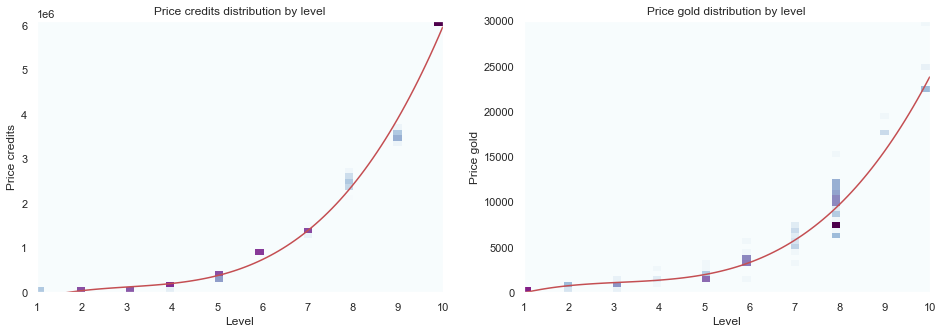

In [9]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

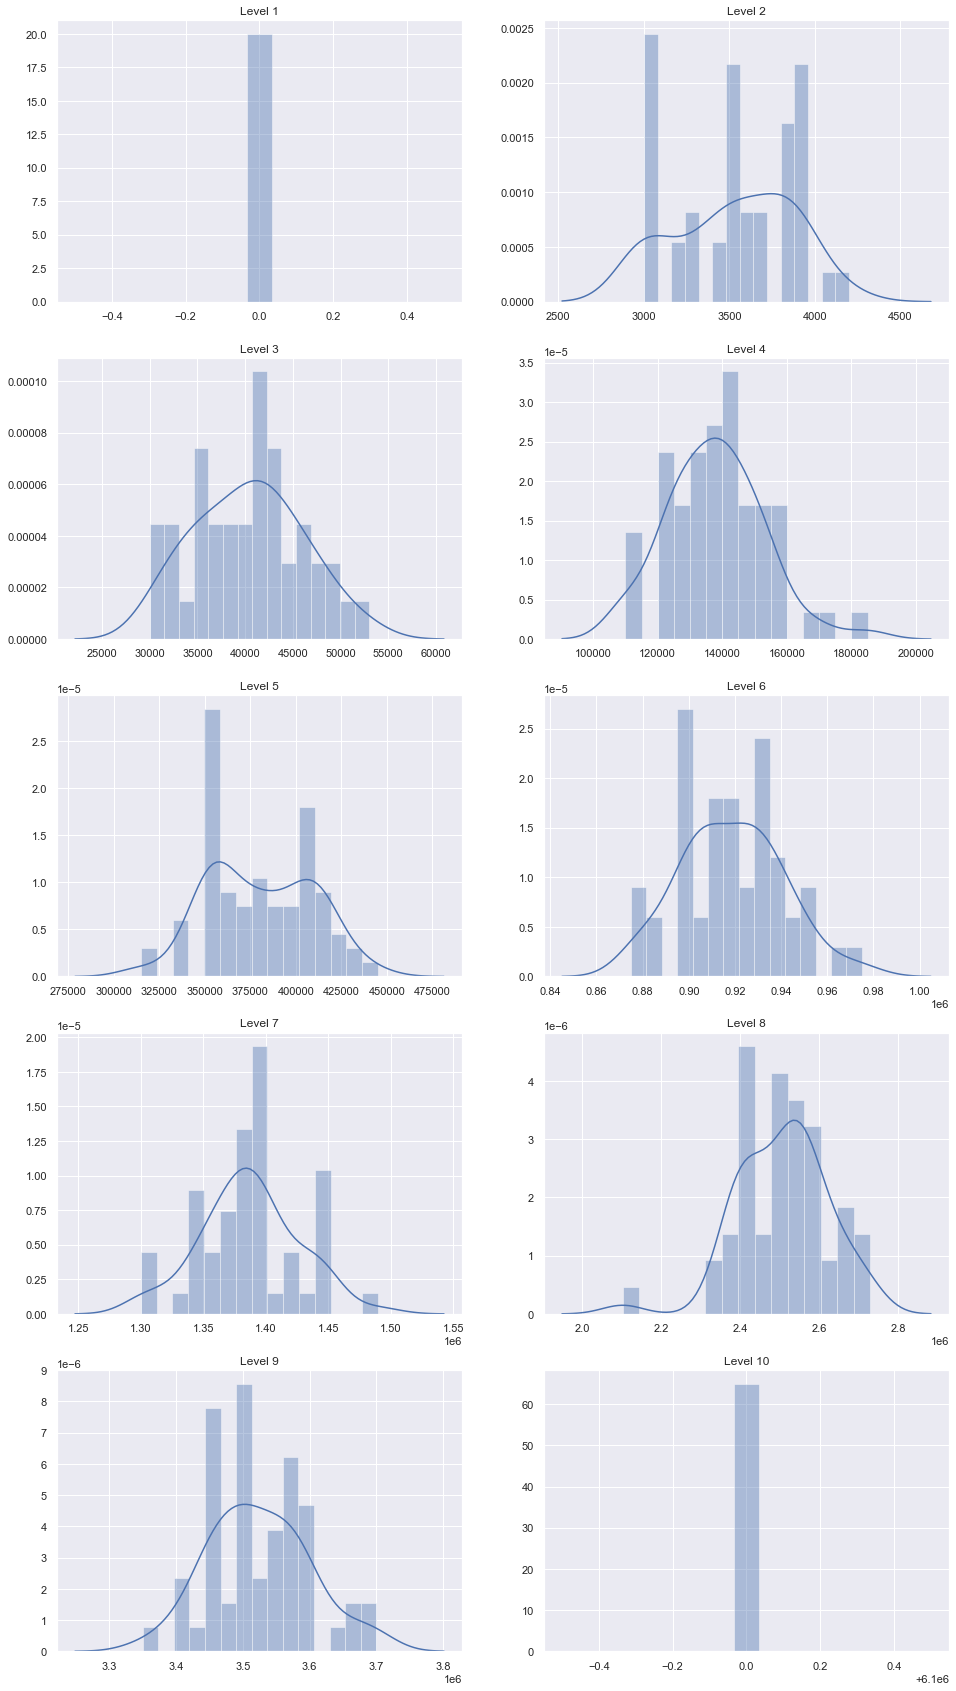

In [10]:
price_ditributions(creds_catalog, price='creds')

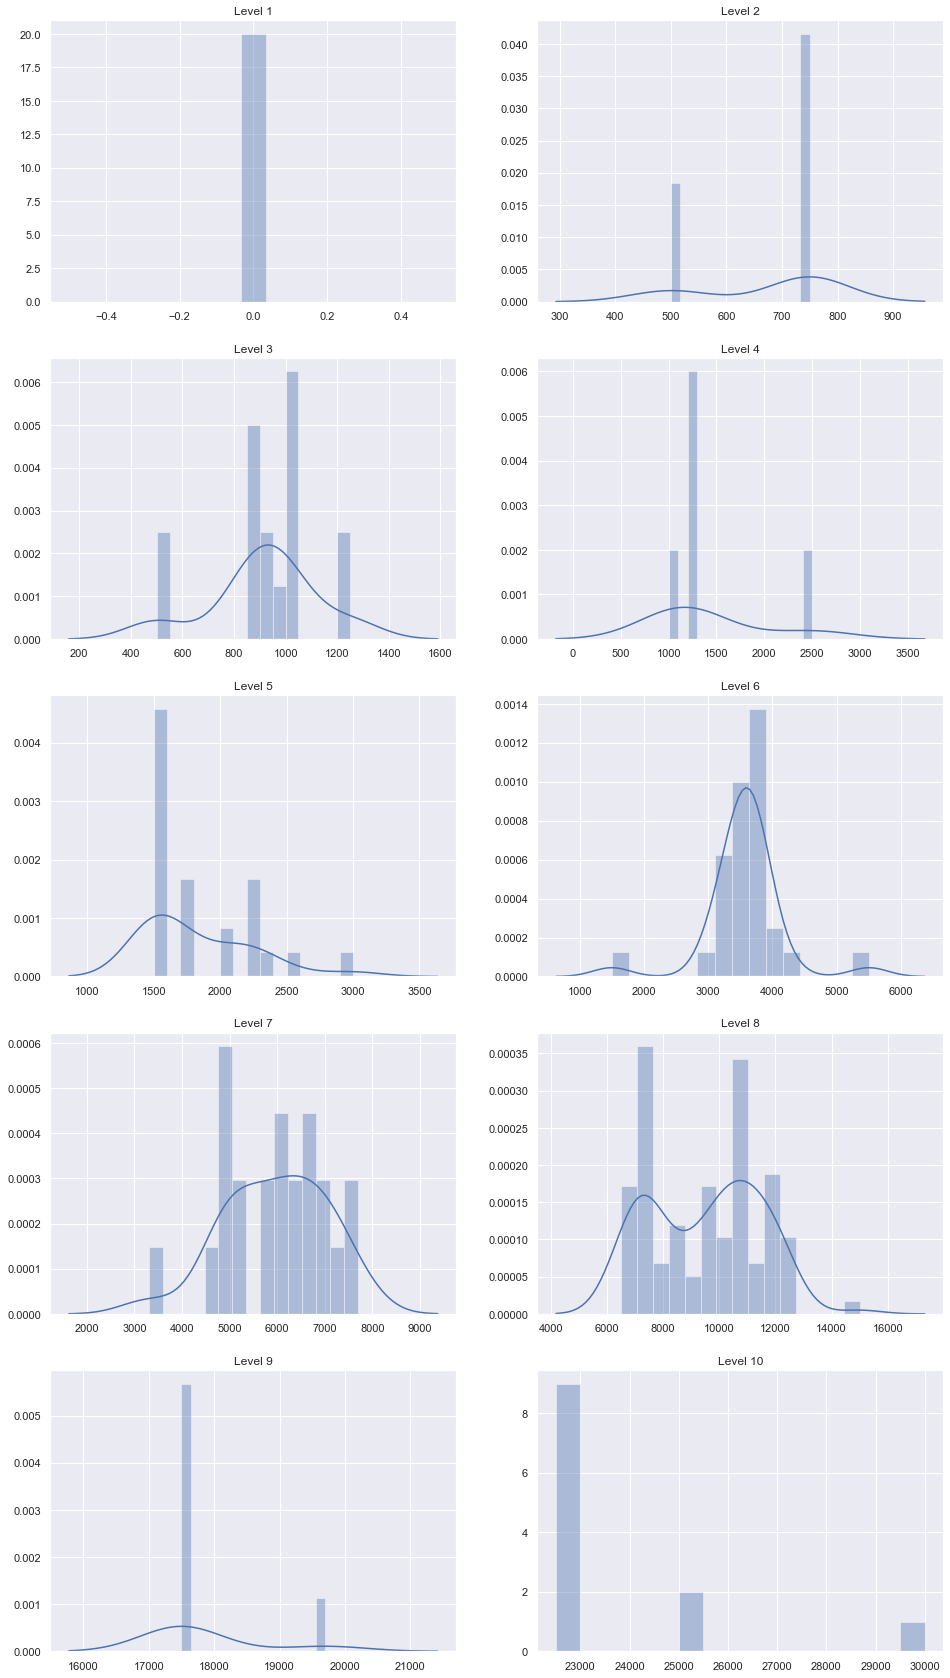

In [11]:
price_ditributions(gold_catalog, price='gold')

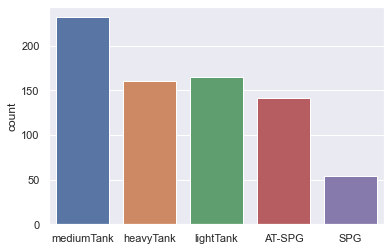

In [12]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

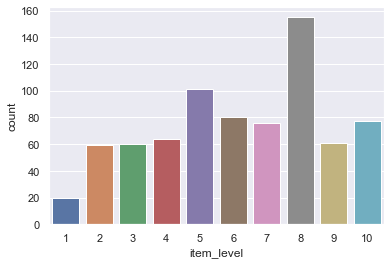

In [13]:
sns.countplot(catalog['item_level']);

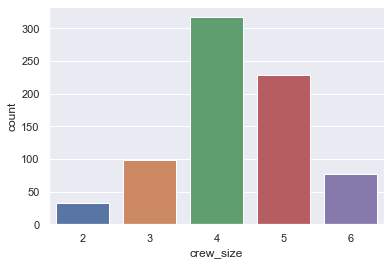

In [14]:
sns.countplot(catalog['crew_size']);

# Arenas data cleaning

In [15]:
N0 = len(arena_members)

masks = [
    ('sync with catalog: vehicle_type_cd not in removed_ids', \
    ~arena_members['vehicle_type_cd'].isin(removed_ids)),
    
    ('removing not standard battles: battle_type_id == 1', \
    arena_members['battle_type_id'] == 1)
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[SYNC WITH CATALOG: VEHICLE_TYPE_CD NOT IN REMOVED_IDS]: removed 687 rows. (0.028295708690118104 %)
[REMOVING NOT STANDARD BATTLES: BATTLE_TYPE_ID == 1]: removed 34193 rows. (1.4087176273656965 %)

Totally removed 34880 rows. (1.4366147294197162 %)


In [16]:
for feature in ['clan_db_id', 'is_prebattle_creator']:
    arena_members[feature] = pd.Categorical(arena_members[feature])

arena_members['dt'] = pd.to_datetime(arena_members['dt'])

In [17]:
N0 = len(arena_members)

print(f'Arena members shape: {arena_members.shape}\n')

N = len(arena_members)
print('[REMOVING DUPLICATES...]', end='   ')
arena_members = arena_members.dropna()
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

N = len(arena_members)
print('[REMOVING NAN...]', end='   ')
arena_members = arena_members[~arena_members.isna()]
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

arena_members.info()

Arena members shape: (2393050, 38)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2393050 entries, 0 to 2393049
Data columns (total 38 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   dt                        datetime64[ns]
 1   arena_id                  object        
 2   periphery_id              int64         
 3   account_db_id             object        
 4   team_id                   int64         
 5   clan_db_id                category      
 6   prebattle_id              int64         
 7   is_prebattle_creator      category      
 8   vehicle_type_cd           int64         
 9   life_time_sec             int64         
 10  shots                     int64         
 11  hits                      int64         
 12  he_hits                   int64         
 13  pierced                   int64   

# Creating normed by time features

In [18]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0

normalize_feature = np.vectorize(normalize_feature)

In [19]:
arena_members['total_damage_dealt'] = arena_members['damage_dealt'] + arena_members['damage_assisted_radio'] + \
                                      arena_members['damage_assisted_stun'] + arena_members['damage_assisted_track']

arena_members['life_time_min'] = arena_members['life_time_sec'] / 60

# Restoring winrates

In [20]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0     
    return winner

arena_members['is_alive'] = arena_members['remained_hp'] > 0

N = len(arena_members)
print('[FILTERING DATA FOR FULL 15x15 TEAMS...]', end='  ')
arena_members = arena_members[arena_members.groupby('arena_id')['account_db_id'].transform('count') == 30]
arena_members.index = np.arange(len(arena_members))
print(f'[FILTERED]: removed {N - len(arena_members)} rows!')

print('[GROUPING BATTLES AND TEAMS...]', end='  ')
battles = arena_members.groupby(['arena_id', 'team_id'])
print(f'[GROUPED BATTLES AND TEAMS]: There are {sum(battles["account_db_id"].count() != 15)} not full teams!')

print('[CALCULATING STATS...]', end='  ')
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
print(f'[CALCULATED STATS]: There are {len(battles) // 2} restored battles!')
    
print('[CALCULATING WINNERS...]', end='  ')
info_df['winner_team_id_my'] = info_df.apply(calc_winner, axis=1)
print('[CALCULATED WINNERS]')

print('[JOINING...]', end='  ')
info_df.reset_index(inplace=True)
arena_members = arena_members.merge(info_df[['index', 'winner_team_id_my']], how='left', left_on='arena_id', right_on='index')
arena_members.drop(columns=['index'], inplace=True, axis=1)
print('[JOINED]')

arena_members['is_winner'] = arena_members['team_id'] == arena_members['winner_team_id']
arena_members['is_winner_my'] = arena_members['team_id'] == arena_members['winner_team_id_my']

[FILTERING DATA FOR FULL 15x15 TEAMS...]  [FILTERED]: removed 18250 rows!
[GROUPING BATTLES AND TEAMS...]  [GROUPED BATTLES AND TEAMS]: There are 0 not full teams!
[CALCULATING STATS...]  [CALCULATED STATS]: There are 79160 restored battles!
[CALCULATING WINNERS...]  [CALCULATED WINNERS]
[JOINING...]  [JOINED]


In [21]:
print(f"Our algorithm accuracy = {100 - 100 * abs(arena_members['is_winner'].sum() - arena_members['is_winner_my'].sum()) / len(arena_members)} %")

Our algorithm accuracy = 99.7043961596766 %


Critical battles number = 3.0


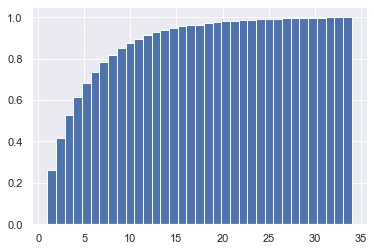

In [22]:
player_battles = arena_members.groupby('account_db_id')['account_db_id'].count()

battles_critical = np.percentile(player_battles, 45)
print(f'Critical battles number = {battles_critical}')

plt.hist(player_battles[player_battles < 35], bins=35, density=True, cumulative=True)
plt.show()

In [23]:
N = len(arena_members)

print('[FILTERING BY CRITICAL BATTLES NUMBER...]', end='   ')
arena_members = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') > battles_critical]
print(f'[FILTERED: removed {N - len(arena_members)} rows.] ({100 - 100 * len(arena_members) / N} %)')

arena_members

[FILTERING BY CRITICAL BATTLES NUMBER...]   [FILTERED: removed 412911 rows.] (17.387190500252657 %)


,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_alive,winner_team_id_my,is_winner,is_winner_my
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,0,1,9,2,3075,6.316667,True,2,True,True
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,0,1,9,2,2607,6.316667,True,2,True,True
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,0,1,9,2,850,5.800000,False,2,False,False
5,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,194,1,9,2,1039,4.916667,False,2,False,False
7,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,1343,1,9,2,2401,5.616667,False,2,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374794,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,0,1,8,1,2076,8.483333,False,1,False,False
2374795,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,0,1,8,1,1377,2.983333,False,1,False,False
2374796,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,0,1,8,1,2619,5.100000,False,1,True,True
2374797,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,0,1,8,1,1011,5.566667,False,1,False,False


In [24]:
players_for_train = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') >= 10]
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                                    'remained_hp' : 'mean',
                                                                    'kills_made' : 'mean',
                                                                    'total_damage_dealt' : 'mean',
                                                                    'damaged' : 'mean',
                                                                    'pierced' : 'mean',
                                                                    'original_credits' : 'mean',
                                                                    'hits' : 'mean',
                                                                    'life_time_min' : 'mean',
                                                                    'damage_assisted_track' : 'mean',
                                                                    'spotted' : 'mean',
                                                                    'pierced_received' : 'mean',
                                                                    'is_winner' : lambda g: sum(g) / len(g)})

features = ['mean_original_xp', 'mean_remained_hp', 'mean_kills_made', 'mean_total_damage_dealt',
                            'mean_damaged', 'mean_pierced', 'mean_original_credits', 'mean_hits',
                            'mean_life_time_min', 'mean_damage_assisted_track', 'mean_spotted', 'mean_pierced_received']
target = ['player_winrate']
players_for_train.columns = features + target

players_for_train

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21117yd2,1258.700000,242.200000,0.500000,1830.800000,3.500000,5.000000,29542.100000,8.000000,4.896667,215.400000,0.900000,4.200000,0.500000
c2111Ncyd,1456.937500,174.229167,1.062500,2285.625000,3.937500,6.645833,70518.937500,9.583333,4.234722,112.916667,1.583333,3.645833,0.583333
c2111TTa7,267.923077,166.769231,0.307692,469.692308,1.461538,1.923077,7834.153846,4.153846,5.701282,0.000000,0.307692,2.615385,0.230769
c2111ad1c,905.571429,76.571429,0.571429,1051.642857,2.714286,3.357143,16515.785714,5.142857,4.694048,20.000000,2.000000,4.714286,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyydN4N,717.600000,25.600000,0.400000,792.800000,2.100000,2.200000,19133.900000,4.000000,4.303333,82.000000,0.300000,4.300000,0.400000
cyyyydyNa,1348.230769,61.615385,0.461538,958.923077,1.692308,2.076923,39881.307692,2.846154,2.833333,57.307692,2.076923,4.000000,0.461538
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630


In [25]:
players_feature_scaler, players_winrate_scaler = StandardScaler(), StandardScaler()

Xn = players_feature_scaler.fit_transform(players_for_train[features])
Yn = players_winrate_scaler.fit_transform(players_for_train[target])

pcaWinrate = PCA(n_components=0.95)
pcaWinrate_components = pcaWinrate.fit_transform(Xn)

numWinrateComponents = pcaWinrate_components.shape[1]

model = GradientBoostingRegressor(n_estimators=600, max_depth=8)
model.fit(Xn, Yn.reshape(len(Yn),))

preds = model.predict(Xn)

#plt.scatter(Xn, Yn, color='gray')
#plt.scatter(Xn, preds, color='red')
#plt.show()

mean_squared_error(Yn, preds)

0.25174975579326686

In [26]:
players_data = arena_members.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                           'remained_hp' : 'mean',
                                                           'kills_made' : 'mean',
                                                           'total_damage_dealt' : 'mean',
                                                           'damaged' : 'mean',
                                                           'pierced' : 'mean',
                                                           'original_credits' : 'mean',
                                                           'hits' : 'mean',
                                                           'life_time_min' : 'mean',
                                                           'damage_assisted_track' : 'mean',
                                                           'spotted' : 'mean',
                                                           'pierced_received' : 'mean',
                                                           'is_winner' : lambda g: sum(g) / len(g)})
players_data.columns = features + target

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21112TT1,865.500000,-0.500000,0.666667,1617.000000,2.166667,5.166667,20181.000000,6.000000,3.272222,180.500000,1.500000,5.333333,0.500000
c211147T2,1718.200000,463.200000,1.000000,2222.800000,3.400000,5.600000,44238.600000,7.600000,5.796667,0.000000,0.800000,3.200000,0.600000
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21114TaT,717.250000,102.125000,1.375000,2784.375000,5.375000,6.250000,29431.750000,9.500000,5.439583,62.375000,1.375000,4.375000,0.500000
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455
cyyyyy42N,924.400000,0.000000,0.200000,1363.200000,2.200000,2.600000,15529.800000,4.400000,3.533333,0.000000,2.000000,5.000000,0.400000
cyyyyyT74,914.875000,239.625000,0.375000,1093.125000,2.625000,2.750000,24891.875000,4.250000,5.895833,45.875000,0.125000,3.500000,0.500000


In [27]:
players_features_normed = players_feature_scaler.transform(players_data[features])
winrateComponents = pcaWinrate.transform(players_features_normed)[:, numWinrateComponents - 1]

players_winrate_normed = model.predict(players_features_normed)
players_data['player_winrate_ML'] = players_winrate_scaler.inverse_transform(players_winrate_normed)

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate,player_winrate_ML
account_db_id,,,,,,,,,,,,,,
c21112TT1,865.500000,-0.500000,0.666667,1617.000000,2.166667,5.166667,20181.000000,6.000000,3.272222,180.500000,1.500000,5.333333,0.500000,0.416399
c211147T2,1718.200000,463.200000,1.000000,2222.800000,3.400000,5.600000,44238.600000,7.600000,5.796667,0.000000,0.800000,3.200000,0.600000,0.624823
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000,0.546359
c21114TaT,717.250000,102.125000,1.375000,2784.375000,5.375000,6.250000,29431.750000,9.500000,5.439583,62.375000,1.375000,4.375000,0.500000,0.420166
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714,0.466523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455,0.531939
cyyyyy42N,924.400000,0.000000,0.200000,1363.200000,2.200000,2.600000,15529.800000,4.400000,3.533333,0.000000,2.000000,5.000000,0.400000,0.504689
cyyyyyT74,914.875000,239.625000,0.375000,1093.125000,2.625000,2.750000,24891.875000,4.250000,5.895833,45.875000,0.125000,3.500000,0.500000,0.453319


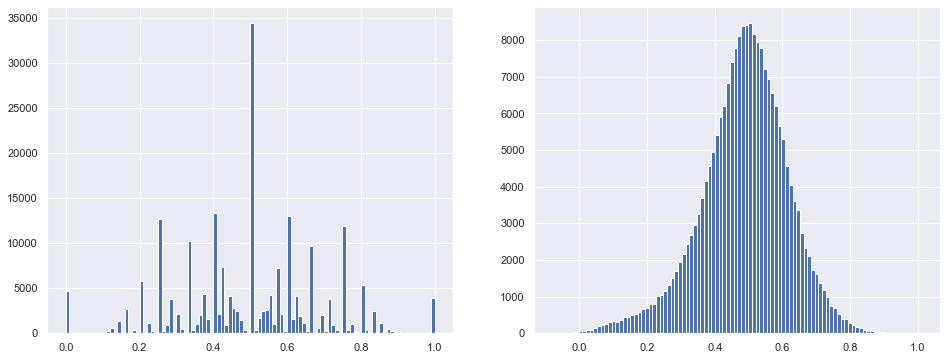

0.4857306676649322

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(players_data['player_winrate'], bins=100)
axes[1].hist(players_data['player_winrate_ML'], bins=100)
plt.show()

players_data['player_winrate_ML'].mean()

In [29]:
arena_members = arena_members.merge(players_data[['player_winrate_ML']], how='left', on='account_db_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_alive,winner_team_id_my,is_winner,is_winner_my,player_winrate_ML
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,1,9,2,3075,6.316667,True,2,True,True,0.639880
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,1,9,2,2607,6.316667,True,2,True,True,0.484306
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,1,9,2,850,5.800000,False,2,False,False,0.428652
3,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,1,9,2,1039,4.916667,False,2,False,False,0.135002
4,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,1,9,2,2401,5.616667,False,2,True,True,0.422010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961884,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,1,8,1,2076,8.483333,False,1,False,False,0.389441
1961885,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,1,8,1,1377,2.983333,False,1,False,False,0.437162
1961886,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1,8,1,2619,5.100000,False,1,True,True,0.628664
1961887,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,1,8,1,1011,5.566667,False,1,False,False,0.606093


In [30]:
N0 = len(arena_members)

masks = [
    ('cleaning by tank battles: vehicle_type_cd.grouped.count >= 100', \
    arena_members.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') >= 100)
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[CLEANING BY TANK BATTLES: VEHICLE_TYPE_CD.GROUPED.COUNT >= 100]: removed 1958 rows. (0.09980177267928658 %)

Totally removed 1958 rows. (0.09980177267928658 %)


In [31]:
tanks_data = arena_members.groupby('vehicle_type_cd').agg({'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['tank_winrate']

tanks_data

,tank_winrate
vehicle_type_cd,
49,0.504088
145,0.493056
273,0.463415
305,0.518851
513,0.507962
...,...
64065,0.504362
64273,0.474610
64561,0.505074


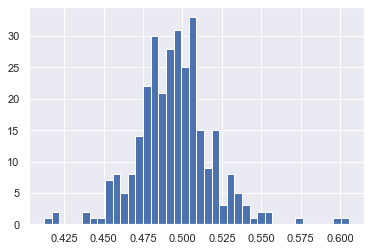

0.4948317646827781

In [32]:
plt.hist(tanks_data['tank_winrate'], bins=40)
plt.show()

tanks_data['tank_winrate'].mean()

In [33]:
arena_members = arena_members.merge(tanks_data[['tank_winrate']], how='left', on='vehicle_type_cd')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_alive,winner_team_id_my,is_winner,is_winner_my,player_winrate_ML,tank_winrate
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,9,2,3075,6.316667,True,2,True,True,0.639880,0.505757
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,9,2,2607,6.316667,True,2,True,True,0.484306,0.493922
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,9,2,850,5.800000,False,2,False,False,0.428652,0.513476
3,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,9,2,1039,4.916667,False,2,False,False,0.135002,0.505757
4,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,9,2,2401,5.616667,False,2,True,True,0.422010,0.506595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,8,1,2076,8.483333,False,1,False,False,0.389441,0.497194
1959927,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,8,1,1377,2.983333,False,1,False,False,0.437162,0.495916
1959928,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,8,1,2619,5.100000,False,1,True,True,0.628664,0.495201
1959929,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,8,1,1011,5.566667,False,1,False,False,0.606093,0.519704


In [34]:
arena_members.drop(columns=['dt', 'periphery_id', 'team_id', 'clan_db_id', 'prebattle_id', 'is_prebattle_creator',
                            'life_time_sec', 'shots', 'hits', 'he_hits', 'pierced', 'mileage_meter', 'premium_xp_factor',
                            'daily_xp_factor', 'battle_num', 'remained_hp', 'is_alive', 'winner_team_id',
                            'winner_team_id_my', 'is_winner', 'is_winner_my'], inplace=True, axis=1)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,premium_xp_factor,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,total_damage_dealt,life_time_min,player_winrate_ML,tank_winrate
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,15,0,0,0,1,9,3075,6.316667,0.639880,0.505757
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,15,0,0,0,1,9,2607,6.316667,0.484306,0.493922
2,7N1T221ccNyadyccT,ca7N4y2y1,3873,850,0,0,0,1250,8,4,...,15,1030,0,0,1,9,850,5.800000,0.428652,0.513476
3,7N1T221ccNyadyccT,cd1T171cy,7457,618,0,421,0,400,2,0,...,15,0,0,194,1,9,1039,4.916667,0.135002,0.505757
4,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,15,1310,0,1343,1,9,2401,5.616667,0.422010,0.506595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,15,0,0,0,1,8,2076,8.483333,0.389441,0.497194
1959927,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,15,1560,0,0,1,8,1377,2.983333,0.437162,0.495916
1959928,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,15,1790,0,0,1,8,2619,5.100000,0.628664,0.495201
1959929,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,15,390,0,0,1,8,1011,5.566667,0.606093,0.519704


# Creating new features

In [35]:
f = arena_members.groupby(['vehicle_type_cd', 'account_db_id'])[['original_credits',
                                                                 'booster_bonus_credits',
                                                                 'booster_bonus_xp',
                                                                 'damage_dealt',
                                                                 'damage_assisted_radio',
                                                                 'damage_assisted_track',
                                                                 'damage_blocked_by_armor',
                                                                 'player_winrate_ML']].mean()

f['normed_damage_dealt'] = (1 - f['player_winrate_ML']) * f['damage_dealt']
f['normed_damage_assisted_radio'] = (1 - f['player_winrate_ML']) * f['damage_assisted_radio']
f['normed_damage_assisted_track'] = (1 - f['player_winrate_ML']) * f['damage_assisted_track']
f['normed_damage_blocked_by_armor'] = (1 - f['player_winrate_ML']) * f['damage_blocked_by_armor']

f = f.groupby(level=0)[['original_credits', 'booster_bonus_credits', 'booster_bonus_xp',
                        'normed_damage_dealt', 'normed_damage_assisted_radio', 'normed_damage_assisted_track',
                        'normed_damage_blocked_by_armor']].mean()
f = f.rename(columns={'original_credits': 'mean_original_credits',
                      'booster_bonus_credits': 'mean_booster_bonus_credits',
                      'booster_bonus_xp': 'mean_booster_bonus_xp'})
f

,mean_original_credits,mean_premium_xp_factor,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
vehicle_type_cd,,,,,,,,
49,51220.040495,14.994504,5414.231501,108.634398,480.673281,220.086351,40.800694,230.562169
145,21582.319444,14.895833,721.041667,139.937500,229.416552,120.016310,15.873109,71.803545
273,19250.403621,15.000000,438.124601,48.105431,341.320580,9.040488,19.559891,0.374530
305,33862.425736,14.983624,2419.095680,91.581787,290.613924,308.320910,20.469956,11.858714
513,17588.710064,14.983460,642.745833,131.283161,339.038821,116.419358,26.907799,142.135419
...,...,...,...,...,...,...,...,...
64065,45455.173292,14.988249,5109.787314,92.982761,480.432838,177.028962,39.053506,111.073656
64273,40430.156189,14.991384,3212.827730,78.069306,404.394775,189.649750,31.095901,65.401970
64561,46620.227286,14.991623,3953.300917,95.189651,473.838622,169.937463,33.969852,539.626823


In [36]:
arena_members = arena_members.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
arena_members.drop(['item_cd'], axis=1, inplace=True)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,battle_level_id,total_damage_dealt,life_time_min,player_winrate_ML,tank_winrate,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,9,3075,6.316667,0.639880,0.505757,1,2700000,0,8,6
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,9,2607,6.316667,0.484306,0.493922,2,2568500,0,8,4
2,7N1T221ccNyadyccT,ca7N4y2y1,3873,850,0,0,0,1250,8,4,...,9,850,5.800000,0.428652,0.513476,2,1450300,0,7,6
3,7N1T221ccNyadyccT,cd1T171cy,7457,618,0,421,0,400,2,0,...,9,1039,4.916667,0.135002,0.505757,1,2700000,0,8,6
4,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,9,2401,5.616667,0.422010,0.506595,2,2600000,0,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,8,2076,8.483333,0.389441,0.497194,0,0,5950,7,4
1959927,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,8,1377,2.983333,0.437162,0.495916,2,0,11800,8,4
1959928,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,8,2619,5.100000,0.628664,0.495201,2,0,12250,8,4
1959929,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,8,1011,5.566667,0.606093,0.519704,2,0,5250,7,4


In [37]:
arena_members = arena_members.merge(f, how='left', on='vehicle_type_cd')
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,item_level,crew_size,mean_original_credits,mean_premium_xp_factor,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,8,6,19949.662240,14.997287,603.874373,96.136541,600.636804,8.688758,16.835138,1.048686
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,8,4,19527.830015,14.989579,551.608609,90.573291,517.305887,146.106356,33.521705,357.150169
2,7N1T221ccNyadyccT,ca7N4y2y1,3873,850,0,0,0,1250,8,4,...,7,6,16586.050905,14.992217,438.095348,75.487029,389.987904,151.033011,29.515537,266.558039
3,7N1T221ccNyadyccT,cd1T171cy,7457,618,0,421,0,400,2,0,...,8,6,19949.662240,14.997287,603.874373,96.136541,600.636804,8.688758,16.835138,1.048686
4,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,8,4,26282.749560,14.993742,1497.145979,336.102321,586.524292,138.204625,37.614655,300.781525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,7,4,32175.622604,15.000000,1674.092733,73.386978,383.743437,91.528377,27.125941,0.660846
1959927,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,8,4,42733.951302,14.990435,3384.956850,82.465981,483.939726,156.528047,38.300229,418.509956
1959928,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,8,4,49792.328939,14.995746,5419.246707,104.534656,463.289295,164.823711,34.908221,408.836234
1959929,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,7,4,30688.979904,15.000000,1692.639740,99.897400,344.890225,119.688133,21.269902,120.972857


In [38]:
dataset = arena_members[['vehicle_type_cd', 'item_class', 'item_level', 'crew_size', 'tank_winrate',
                         'mean_original_credits', 'mean_booster_bonus_credits',
                         'mean_booster_bonus_xp', 'normed_damage_dealt', 'normed_damage_assisted_radio',
                         'normed_damage_assisted_track', 'normed_damage_blocked_by_armor',
                         'item_price_credit', 'item_price_gold']]
dataset

,vehicle_type_cd,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_premium_xp_factor,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_credit,item_price_gold
0,7457,1,8,6,0.505757,19949.662240,14.997287,603.874373,96.136541,600.636804,8.688758,16.835138,1.048686,2700000,0
1,5377,2,8,4,0.493922,19527.830015,14.989579,551.608609,90.573291,517.305887,146.106356,33.521705,357.150169,2568500,0
2,3873,2,7,6,0.513476,16586.050905,14.992217,438.095348,75.487029,389.987904,151.033011,29.515537,266.558039,1450300,0
3,7457,1,8,6,0.505757,19949.662240,14.997287,603.874373,96.136541,600.636804,8.688758,16.835138,1.048686,2700000,0
4,2961,2,8,4,0.506595,26282.749560,14.993742,1497.145979,336.102321,586.524292,138.204625,37.614655,300.781525,2600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,61713,0,7,4,0.497194,32175.622604,15.000000,1674.092733,73.386978,383.743437,91.528377,27.125941,0.660846,0,5950
1959927,9217,2,8,4,0.495916,42733.951302,14.990435,3384.956850,82.465981,483.939726,156.528047,38.300229,418.509956,0,11800
1959928,65073,2,8,4,0.495201,49792.328939,14.995746,5419.246707,104.534656,463.289295,164.823711,34.908221,408.836234,0,12250
1959929,59137,2,7,4,0.519704,30688.979904,15.000000,1692.639740,99.897400,344.890225,119.688133,21.269902,120.972857,0,5250


# Correlations

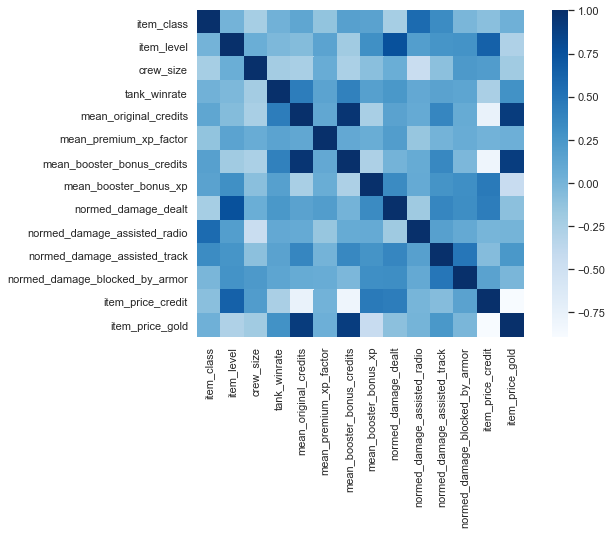

item_price_credit                -0.890630
mean_booster_bonus_xp            -0.433828
item_level                       -0.282797
crew_size                        -0.197725
normed_damage_dealt              -0.095038
normed_damage_blocked_by_armor   -0.013398
normed_damage_assisted_radio      0.010163
item_class                        0.039370
mean_premium_xp_factor            0.043535
normed_damage_assisted_track      0.242140
tank_winrate                      0.289852
mean_booster_bonus_credits        0.902248
mean_original_credits             0.911362
item_price_gold                   1.000000
Name: item_price_gold, dtype: float64

In [51]:
corr = dataset.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [52]:
res_data = dataset.groupby('vehicle_type_cd').mean().reset_index()
tank_params = res_data[res_data['vehicle_type_cd'] == 9217]
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

res_data.drop(columns=['vehicle_type_cd'], inplace=True, axis=1)

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_premium_xp_factor,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,4,8,4,0.504088,51220.040495,14.994504,5414.231501,108.634398,480.673281,220.086351,40.800694,230.562169,7500
1,4,6,5,0.493056,21582.319444,14.895833,721.041667,139.937500,229.416552,120.016310,15.873109,71.803545,3650
2,3,7,4,0.518851,33862.425736,14.983624,2419.095680,91.581787,290.613924,308.320910,20.469956,11.858714,4800
3,2,8,4,0.506536,46795.680606,14.994198,4595.123147,84.616953,498.896845,189.702437,39.372930,410.380887,12250
4,2,8,4,0.521193,52728.084989,14.984071,4933.055223,137.468103,606.565783,159.715226,34.170686,394.044875,10700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2,8,5,0.504362,45455.173292,14.988249,5109.787314,92.982761,480.432838,177.028962,39.053506,111.073656,11900
81,4,8,4,0.474610,40430.156189,14.991384,3212.827730,78.069306,404.394775,189.649750,31.095901,65.401970,8700
82,2,8,4,0.505074,46620.227286,14.991623,3953.300917,95.189651,473.838622,169.937463,33.969852,539.626823,10500
83,3,6,5,0.520567,25118.365412,14.934877,1086.765557,60.574530,238.980600,209.272593,10.796943,0.451753,3500


In [53]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_premium_xp_factor,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,1.047570,0.497419,-0.526670,0.047485,0.951285,0.295699,1.091725,0.916630,0.097037,0.696742,0.774844,0.147166,-0.309826
1,1.047570,-2.230361,0.829905,-0.452363,-1.874484,-4.272540,-1.681280,2.522437,-1.562567,-0.846022,-1.390834,-0.701311,-1.489608
2,0.362620,-0.866471,-0.526670,0.716332,-0.703654,-0.208011,-0.677973,0.041855,-1.158345,2.057041,-0.991466,-1.021683,-1.137206
3,-0.322329,0.497419,-0.526670,0.158364,0.529451,0.281522,0.607748,-0.315432,0.217408,0.228318,0.650801,1.108197,1.145750
4,-0.322329,0.497419,-0.526670,0.822444,1.095068,-0.187340,0.807418,2.395760,0.928584,-0.233990,0.198837,1.020890,0.670773
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,-0.322329,0.497419,0.829905,0.059879,0.401642,0.006087,0.911841,0.113723,0.095449,0.032933,0.623050,-0.491434,1.038497
81,1.047570,0.497419,-0.526670,-1.288056,-0.077462,0.151250,-0.208991,-0.651317,-0.406798,0.227506,-0.068297,-0.735524,0.057899
82,-0.322329,0.497419,-0.526670,0.092139,0.512722,0.162314,0.228523,0.226933,0.051893,-0.076396,0.181389,1.798945,0.609485
83,0.362620,-2.230361,0.829905,0.794096,-1.537345,-2.464908,-1.465190,-1.548775,-1.499394,0.530028,-1.831845,-1.082647,-1.535574


In [54]:
train_data = np.array(normed_gold_dataset.drop(columns=['item_price_gold']))
train_labels = np.array(normed_gold_dataset[['item_price_gold']])

Train on 76 samples, validate on 9 samples
Epoch 1/100
76/76 [==============================] - 1s 10ms/sample - loss: 1.2204 - val_loss: 0.5625
Epoch 2/100
76/76 [==============================] - 0s 223us/sample - loss: 0.8217 - val_loss: 0.4494
Epoch 3/100
76/76 [==============================] - 0s 262us/sample - loss: 0.6238 - val_loss: 0.3740
Epoch 4/100
76/76 [==============================] - 0s 258us/sample - loss: 0.5020 - val_loss: 0.3466
Epoch 5/100
76/76 [==============================] - 0s 262us/sample - loss: 0.4347 - val_loss: 0.3164
Epoch 6/100
76/76 [==============================] - 0s 302us/sample - loss: 0.3876 - val_loss: 0.3032
Epoch 7/100
76/76 [==============================] - 0s 394us/sample - loss: 0.2940 - val_loss: 0.2825
Epoch 8/100
76/76 [==============================] - 0s 278us/sample - loss: 0.2252 - val_loss: 0.2737
Epoch 9/100
76/76 [==============================] - 0s 328us/sample - loss: 0.2278 - val_loss: 0.2677
Epoch 10/100
76/76 [===========

76/76 [==============================] - 0s 289us/sample - loss: 0.0339 - val_loss: 0.2067
Epoch 80/100
76/76 [==============================] - 0s 289us/sample - loss: 0.0245 - val_loss: 0.2016
Epoch 81/100
76/76 [==============================] - 0s 315us/sample - loss: 0.0234 - val_loss: 0.2007
Epoch 82/100
76/76 [==============================] - 0s 262us/sample - loss: 0.0205 - val_loss: 0.2045
Epoch 83/100
76/76 [==============================] - 0s 315us/sample - loss: 0.0296 - val_loss: 0.1806
Epoch 84/100
76/76 [==============================] - 0s 276us/sample - loss: 0.0249 - val_loss: 0.2043
Epoch 85/100
76/76 [==============================] - 0s 289us/sample - loss: 0.0290 - val_loss: 0.1901
Epoch 86/100
76/76 [==============================] - 0s 315us/sample - loss: 0.0319 - val_loss: 0.2143
Epoch 87/100
76/76 [==============================] - 0s 289us/sample - loss: 0.0262 - val_loss: 0.1776
Epoch 88/100
76/76 [==============================] - 0s 289us/sample - loss:

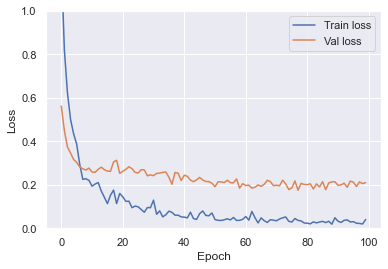

In [125]:
epochs = 100

model = build_network(train_data.shape[1])
history = model.fit(train_data, train_labels,
                    validation_split=0.1,
                    epochs=epochs, shuffle=True)

plot_network_history(history)

In [85]:
full_model = build_network(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=epochs, shuffle=True)

Train on 85 samples
Epoch 1/300
85/85 [==============================] - 1s 9ms/sample - loss: 1.0643
Epoch 2/300
85/85 [==============================] - 0s 129us/sample - loss: 0.8603
Epoch 3/300
85/85 [==============================] - 0s 117us/sample - loss: 0.7736
Epoch 4/300
85/85 [==============================] - 0s 153us/sample - loss: 0.6891
Epoch 5/300
85/85 [==============================] - 0s 112us/sample - loss: 0.6128
Epoch 6/300
85/85 [==============================] - 0s 117us/sample - loss: 0.5375
Epoch 7/300
85/85 [==============================] - 0s 153us/sample - loss: 0.4656
Epoch 8/300
85/85 [==============================] - 0s 141us/sample - loss: 0.3994
Epoch 9/300
85/85 [==============================] - 0s 176us/sample - loss: 0.3468
Epoch 10/300
85/85 [==============================] - 0s 141us/sample - loss: 0.2875
Epoch 11/300
85/85 [==============================] - 0s 117us/sample - loss: 0.2447
Epoch 12/300
85/85 [==============================] - 0s

85/85 [==============================] - 0s 164us/sample - loss: 0.0067
Epoch 98/300
85/85 [==============================] - 0s 153us/sample - loss: 0.0025
Epoch 99/300
85/85 [==============================] - 0s 117us/sample - loss: 0.0067
Epoch 100/300
85/85 [==============================] - 0s 164us/sample - loss: 0.0056
Epoch 101/300
85/85 [==============================] - 0s 117us/sample - loss: 0.0031
Epoch 102/300
85/85 [==============================] - 0s 164us/sample - loss: 0.0065
Epoch 103/300
85/85 [==============================] - 0s 117us/sample - loss: 0.0181
Epoch 104/300
85/85 [==============================] - 0s 199us/sample - loss: 0.0194
Epoch 105/300
85/85 [==============================] - 0s 153us/sample - loss: 0.0124
Epoch 106/300
85/85 [==============================] - 0s 164us/sample - loss: 0.0117
Epoch 107/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0041
Epoch 108/300
85/85 [==============================] - 0s 129us/sample

85/85 [==============================] - 0s 164us/sample - loss: 0.0047
Epoch 193/300
85/85 [==============================] - 0s 117us/sample - loss: 0.0013
Epoch 194/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0027
Epoch 195/300
85/85 [==============================] - 0s 94us/sample - loss: 0.0180
Epoch 196/300
85/85 [==============================] - 0s 94us/sample - loss: 0.0101
Epoch 197/300
85/85 [==============================] - 0s 164us/sample - loss: 0.0031
Epoch 198/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0101
Epoch 199/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0039
Epoch 200/300
85/85 [==============================] - 0s 129us/sample - loss: 6.6131e-04
Epoch 201/300
85/85 [==============================] - 0s 117us/sample - loss: 8.0626e-04
Epoch 202/300
85/85 [==============================] - 0s 106us/sample - loss: 0.0022
Epoch 203/300
85/85 [==============================] - 0s 117u

85/85 [==============================] - 0s 106us/sample - loss: 0.0056
Epoch 287/300
85/85 [==============================] - 0s 94us/sample - loss: 0.0025
Epoch 288/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0031
Epoch 289/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0018
Epoch 290/300
85/85 [==============================] - 0s 153us/sample - loss: 0.0026
Epoch 291/300
85/85 [==============================] - 0s 129us/sample - loss: 0.0025
Epoch 292/300
85/85 [==============================] - 0s 153us/sample - loss: 0.0071
Epoch 293/300
85/85 [==============================] - 0s 141us/sample - loss: 0.0030
Epoch 294/300
85/85 [==============================] - 0s 153us/sample - loss: 0.0022
Epoch 295/300
85/85 [==============================] - 0s 129us/sample - loss: 8.9575e-04
Epoch 296/300
85/85 [==============================] - 0s 117us/sample - loss: 5.6418e-04
Epoch 297/300
85/85 [==============================] - 0s 106

In [58]:
tank_params.drop(columns=['vehicle_type_cd', 'item_price_credit', 'item_price_gold'], inplace=True, axis=1)
tank_params

,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_premium_xp_factor,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
125,2,8,4,0.495916,42733.951302,14.990435,3384.95685,82.465981,483.939726,156.528047,38.300229,418.509956


In [126]:
def predict(tank_params):
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    
    pred_full = full_model.predict(scaled)
    pred = model.predict(scaled)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x = np.concatenate((scaled[0], pred[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x)[-1]

predict(tank_params)

(10586.23740506301, 11789.01130577241)

# Tests

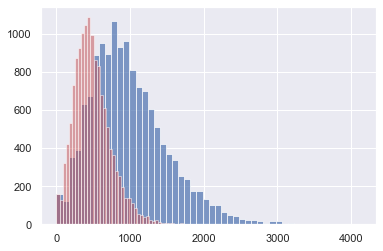

In [60]:
damage = arena_members[arena_members['vehicle_type_cd'] == 9217][['account_db_id', 'damage_dealt', 'player_winrate_ML']]
damage = damage[damage.groupby('account_db_id')['account_db_id'].transform('count') >= 2]

pl = damage.groupby('account_db_id').agg({'damage_dealt' : lambda g: g.mean(),
                                          'player_winrate_ML' : 'mean'})
pl['normed'] = (1 - pl['player_winrate_ML']) * pl['damage_dealt']

plt.hist(pl['damage_dealt'], bins=50, alpha=0.7)
plt.hist(pl['normed'], bins=50, color='r', alpha=0.5)
plt.show()

In [127]:
gb = GradientBoostingRegressor(n_estimators=400, max_depth=6, min_samples_split=4)
rf = RandomForestRegressor(n_estimators=400, max_depth=10, min_samples_split=6)
svm1 = SVR(C=100, gamma=0.01, kernel='rbf')
svm2 = SVR(C=1000, gamma=0.01, coef0=1, degree=2, kernel='poly')
ab = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=400)
nn = KerasRegressor(build_fn=build_network, inputs=train_data.shape[1], epochs=100)
nn._estimator_type = 'regressor'

model = VotingRegressor([('gb', gb),
                         ('rf', rf),
                         ('svm1', svm1),
                         ('svm2', svm2),
                         ('ab', ab),
                         ('nn', nn)], weights=[1, 1, 1, 1, 1, 1])

res = model.fit(train_data, train_labels)

Train on 85 samples
Epoch 1/100
85/85 [==============================] - 1s 6ms/sample - loss: 0.9116
Epoch 2/100
85/85 [==============================] - 0s 129us/sample - loss: 0.6340
Epoch 3/100
85/85 [==============================] - 0s 106us/sample - loss: 0.6343
Epoch 4/100
85/85 [==============================] - 0s 129us/sample - loss: 0.3430
Epoch 5/100
85/85 [==============================] - 0s 94us/sample - loss: 0.3621
Epoch 6/100
85/85 [==============================] - 0s 117us/sample - loss: 0.2614
Epoch 7/100
85/85 [==============================] - 0s 141us/sample - loss: 0.3553
Epoch 8/100
85/85 [==============================] - 0s 141us/sample - loss: 0.2601
Epoch 9/100
85/85 [==============================] - 0s 129us/sample - loss: 0.2338
Epoch 10/100
85/85 [==============================] - 0s 117us/sample - loss: 0.2072
Epoch 11/100
85/85 [==============================] - 0s 117us/sample - loss: 0.1739
Epoch 12/100
85/85 [==============================] - 0s 

85/85 [==============================] - 0s 117us/sample - loss: 0.0208
Epoch 98/100
85/85 [==============================] - 0s 106us/sample - loss: 0.0388
Epoch 99/100
85/85 [==============================] - 0s 129us/sample - loss: 0.0361
Epoch 100/100
85/85 [==============================] - 0s 106us/sample - loss: 0.0394


In [128]:
tank_params['item_price_gold'] = 0

scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
pred = model.predict(scaled)
x = np.concatenate((scaled[0], pred))

gold_scaler.inverse_transform(x)[-1]

11237.341470179921